In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
from collections import deque
import random

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 128
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.X = tf.placeholder(tf.float32, (None, None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, None, self.state_size))
        self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * self.LAYER_SIZE))
        self.ACTION = tf.placeholder(tf.float32, (None))
        self.REWARD = tf.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(self.ACTION)[0]
        self.seq_len = tf.shape(self.X)[1]
        
        with tf.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1,1))
            repeat_action = tf.tile(action, [1,self.seq_len,1])
            state_action = tf.concat([self.X, repeat_action], axis=-1)
            save_state = tf.identity(self.Y)
            cell = tf.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
            self.rnn,last_state = tf.nn.dynamic_rnn(inputs=state_action,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            self.curiosity_logits = tf.layers.dense(self.rnn[:,-1], self.state_size)
            self.curiosity_cost = tf.reduce_sum(tf.square(save_state[:,-1] - self.curiosity_logits), axis=1)
            
            self.curiosity_optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(self.curiosity_cost))
        
        total_reward = tf.add(self.curiosity_cost, self.REWARD)
        
        with tf.variable_scope("q_model"):
            with tf.variable_scope("eval_net"):
                cell = tf.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
                rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
                self.logits = tf.layers.dense(rnn[:,-1], self.OUTPUT_SIZE)
            
            with tf.variable_scope("target_net"):
                cell = tf.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
                rnn,last_state = tf.nn.dynamic_rnn(inputs=self.Y,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
                y_q = tf.layers.dense(rnn[:,-1], self.OUTPUT_SIZE)
            
            q_target = total_reward + self.GAMMA * tf.reduce_max(y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.losses.mean_squared_error(labels=q_target, predictions=q)
            self.optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))
            
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, done, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, done, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)
            
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards,
            self.hidden_layer: init_values
        })
        
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards,
                self.hidden_layer: init_values
            })
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            
            if np.random.rand() < self.EPSILON:
                action = np.random.randint(self.OUTPUT_SIZE)
            else:
                action, last_state = self.sess.run([self.logits,
                                                  self.last_state],
                                                  feed_dict={self.X:[self.INITIAL_FEATURES],
                                                             self.hidden_layer:init_value})
                action, init_value = np.argmax(action[0]), last_state
                    
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.logits,
                                                  self.last_state],
                                                  feed_dict={self.X:[self.INITIAL_FEATURES],
                                                             self.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 685.860168.3, cost: 4139534.500000, total money: 977.580137
epoch: 20, total rewards: 1724.255003.3, cost: 5132677.500000, total money: 5851.904966
epoch: 30, total rewards: 493.970035.3, cost: 3979546.750000, total money: 8528.600039
epoch: 40, total rewards: 1580.255128.3, cost: 5099559.000000, total money: 4018.855103
epoch: 50, total rewards: 1467.990231.3, cost: 4410721.500000, total money: 8490.720211
epoch: 60, total rewards: 1285.420161.3, cost: 3993190.000000, total money: 2688.440118
epoch: 70, total rewards: 391.130068.3, cost: 3420379.000000, total money: 6491.710085
epoch: 80, total rewards: 1276.110108.3, cost: 3443612.750000, total money: 3698.110047
epoch: 90, total rewards: 672.475340.3, cost: 2882908.000000, total money: 208.605285
epoch: 100, total rewards: 706.604982.3, cost: 3108476.500000, total money: 1169.724916
epoch: 110, total rewards: 979.940367.3, cost: 2024909.750000, total money: 3200.720335
epoch: 120, total rewards: 853.199893.

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1, sell 1 unit at price 762.130005, investment -0.854691 %, total balance 9993.429993,
day 4: buy 1 unit at price 790.510010, total balance 9202.919983
day 5: buy 1 unit at price 785.309998, total balance 8417.609985
day 8: buy 1 unit at price 736.080017, total balance 7681.529968
day 9: buy 1 unit at price 758.489990, total balance 6923.039978
day 11, sell 1 unit at price 771.229980, investment -2.438936 %, total balance 7694.269958,
day 13: buy 1 unit at price 769.200012, total balance 6925.069946
day 17: buy 1 unit at price 768.239990, total balance 6156.829956
day 19, sell 1 unit at price 758.039978, investment -3.472517 %, total balance 6914.869934,
day 25, sell 1 unit at price 776.419983, investment 5.480378 %, total balance 7691.289917,
day 26: buy 1 unit at price 789.289978, total balance 6901.999939
day 28: buy 1 unit at price 796.099976, total balance 6105.899963
day 31: buy 1 unit at price 790.799988, total

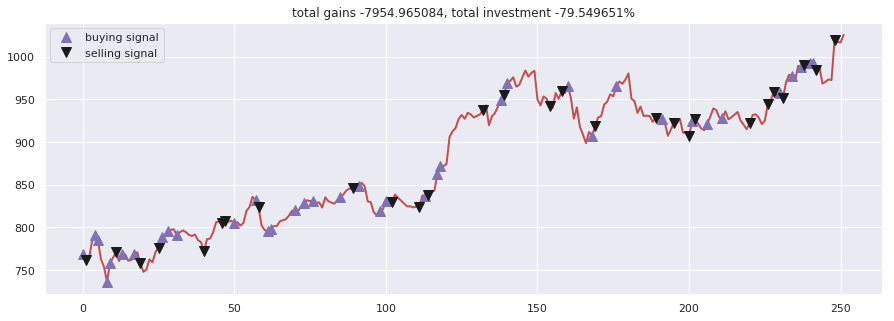

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()